# Tortured sentences detection: using a first machine learning approach

Author: Alexandre Clausse.

## Introduction

This document aims to present how to process the dataset extracted from the [PPS](https://dbrech.irit.fr/pls/apex/f?p=9999:1::::::), for supervised learning application.

It includes the training of three Natural Language Processing (NLP) state-of-the-art models:
- A Long Short Term Memory (LSTM) architecture (being a Recurrent Neural Network - RNN).
- A Convolutional Neural Network (CNN).
- And a combination of the upper models through Recurrent Convolutional Neural Network (RCNN).

## Requirements

We run this experiment using Python 3.10, but the below models are trained with Python 3.6.8.

We use the following Python libraries:
```
nltk==3.7                # A natural language toolkit
scikit-learn==1.2.1      # For scientific computations
unidecode==1.3.6         # For unicode characters decoding
tqdm==4.64.1             # A progress bar for Python
matplotlib==3.6.3        # For data visualisation
pandas==1.5.0            # A data science library
numpy==1.24.1            # Also for scientific computations
keras==2.11.0            # For machine learning implementations
tensorflow==2.11.0       # Needed by Keras
imbalanced-learn==0.10.1 # For dataset undersampling / oversampling
```

These can be stored in a list in order to be installed with the `pip3 install -r dependencies.txt` command.

Documentations:
- Nltk: https://www.nltk.org/
- Scikit-learn: https://scikit-learn.org/
- Unidecode: https://pypi.org/project/Unidecode/
- Tqdm: https://pypi.org/project/tqdm/2.2.3/
- Matplotlib: https://matplotlib.org/
- Pandas: https://pandas.pydata.org/
- Numpy: https://numpy.org/doc/stable/
- Keras: https://keras.io/
- TensorFlow: https://www.tensorflow.org/
- Imbalanced-learn: https://imbalanced-learn.org/stable/

We also use the following built-in Python libraries:
```
os     # For OS operations
io     # For I/O operations
re     # For regex computations
pickle # For data serialisation
glob   # For Linux-like path exploration
```

In [2]:
# Imports
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from unidecode import unidecode
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, io, re, pickle

tqdm.pandas()
SEED=1337

## Dataset processing

First, we read both assessments and papers from the dataset:

In [5]:
# Reading data
def read_content(path:str) -> str:
    with io.open(path, "r", encoding="utf-8") as handle:
        content = handle.read()
        handle.close()
    return content

metadata = pd.read_csv(os.path.join("dataset", "_metadata.csv"), encoding="utf-8")
metadata["content"] = metadata["DOI"].progress_apply(lambda p: read_content(os.path.join("dataset", "%s.txt" % (p.split("/")[-1]))))
display(metadata.head())

100%|██████████| 2043/2043 [00:00<00:00, 4054.21it/s]


,DOI,Tortured Phrases,filename,content
0,10.1109/iccmc51019.2021.9418051,concealed layer • counterfeit neural • fluffy ...,iccmc51019.2021.9418051.pdf,A Convenient Machine Learning Model for Cyber ...
1,10.1109/iceca52323.2021.9676104,blunder rate • condition of-craftsmanship • cr...,iceca52323.2021.9676104.pdf,IMPROVED FACE RECOGNITION USING \nCONVOLUTIONA...
2,10.1109/icacccn.2018.8748454,Wavelet change • bolster vector machine • choi...,icacccn.2018.8748454.pdf,International Conference on Advances in Comput...
3,10.1109/icears53579.2022.9751876,bogus up-sides • decent contender • dimensiona...,icears53579.2022.9751876.pdf,\nAnomaly Identification Performed Independen...
4,10.1109/icears53579.2022.9752228,crude information • decidedly charged • direct...,icears53579.2022.9752228.pdf,"\nG MANI \nAssistant Professor, Department of..."


We format the tortured sentences by applying:
- Tortured sentences splitting and filtering.
- Sentence lowerisation.
- Numeric chracaters removal.
- Tildes/dashes/parenthesis removal.
- Underscore replacement with whitespace.

In [6]:
# Metadata processing
def process_tortured_sentences(s:str) -> list:
    bad_characters = ["~", "-", "(", ")"]
    processed_sentences = list()
    for e in s.split(" • "):                                                 # tortured sentence filtering
        processed_sentences += e.split(" AND ")[0].split(" OR ")             # tortured sentence filtering
    for i in range(len(processed_sentences)):  
        processed_sentences[i] = processed_sentences[i].lower()              # sentence lowerisation
        processed_sentences[i] = re.sub("[0-9]", "", processed_sentences[i]) # numeric characters removal
        for bc in bad_characters:
            processed_sentences[i] = processed_sentences[i].replace(bc, "")  # tildes/dashes/parenthesis removal
        processed_sentences[i] = processed_sentences[i].replace("_", " ")    # underscore replacement
    return processed_sentences

metadata["Tortured Phrases"] = metadata["Tortured Phrases"].progress_apply(process_tortured_sentences)
print(metadata.head()["Tortured Phrases"].values)

100%|██████████| 2043/2043 [00:00<00:00, 81369.71it/s]

[list(['concealed layer', 'counterfeit neural', 'fluffy rationale', 'gatherings clustering', 'hereditary calculation', 'highlight extraction', 'keen matrix', 'preparation information', 'profound neural organization', 'profound neural system', 'profound learning'])
 list(['blunder rate', 'condition ofcraftsmanship', 'crude information', 'discrete cosine change', 'facial highlights', 'feeling acknowledgment', 'head part examination', 'manmade consciousness', 'misfortune layer', 'prehandling', 'preparation information', 'profound convolutional', 'profound learning'])
 list(['wavelet change', 'bolster vector machine', 'choice tree', 'convolutional neural system', 'help vector machine', 'likelihood appropriation', 'profound convolutional', 'shrouded markov'])
 list(['bogus upsides', 'decent contender', 'dimensionality decrease', 'head part examination', 'highlight extraction', 'preparation information', 'profound learning'])
 list(['crude information', 'decidedly charged', 'direct relapse',

We perform the following processing on the corpus (as described in the exploratory dataset analysis):
- Sentence lowerisation.
- Escape characters removal.
- Sentence tokenisation.
- Non unicode characters removal.
- Underscores replacement.
- Non-alphanumeric characters removal.
- Word tokenisation.
- Stopwords removal.
- Most occurrent noisy bigrams and trigrams removal.
- Quotes removal.
- Single characters and empty sentences removal.

In [7]:
# Content processing
def process_content(content:str) -> list:
    content = content.lower().replace("\n", "")                 # Content lowerisation
    content = sent_tokenize(content)                            # Sentence tokenisation
    content = [unidecode(e) for e in content]                   # Non unicode characters removal
    content = [e.replace("_", " ") for e in content]            # Underscore replacement
    content = [re.sub("[^0-9a-zA-Z ]", "", e) for e in content] # Non-alphanumeric character removal
    content = [word_tokenize(e) for e in content]               # Word tokenisation
    return content

metadata["content"] = metadata["content"].progress_apply(process_content)
display(metadata.head())

100%|██████████| 2043/2043 [01:42<00:00, 20.02it/s] 


,DOI,Tortured Phrases,filename,content
0,10.1109/iccmc51019.2021.9418051,"[concealed layer, counterfeit neural, fluffy r...",iccmc51019.2021.9418051.pdf,"[[a, convenient, machine, learning, model, for..."
1,10.1109/iceca52323.2021.9676104,"[blunder rate, condition ofcraftsmanship, crud...",iceca52323.2021.9676104.pdf,"[[improved, face, recognition, using, convolut..."
2,10.1109/icacccn.2018.8748454,"[wavelet change, bolster vector machine, choic...",icacccn.2018.8748454.pdf,"[[international, conference, on, advances, in,..."
3,10.1109/icears53579.2022.9751876,"[bogus upsides, decent contender, dimensionali...",icears53579.2022.9751876.pdf,"[[anomaly, identification, performed, independ..."
4,10.1109/icears53579.2022.9752228,"[crude information, decidedly charged, direct ...",icears53579.2022.9752228.pdf,"[[g, mani, assistant, professor, department, o..."


In [8]:
# Removing stopwords
sw = set(stopwords.words("english"))
metadata["content"] = metadata["content"].progress_apply(lambda c: [[word for word in sentence if word not in sw] for sentence in c])
display(metadata.head())

100%|██████████| 2043/2043 [00:01<00:00, 1040.10it/s]


,DOI,Tortured Phrases,filename,content
0,10.1109/iccmc51019.2021.9418051,"[concealed layer, counterfeit neural, fluffy r...",iccmc51019.2021.9418051.pdf,"[[convenient, machine, learning, model, cyber,..."
1,10.1109/iceca52323.2021.9676104,"[blunder rate, condition ofcraftsmanship, crud...",iceca52323.2021.9676104.pdf,"[[improved, face, recognition, using, convolut..."
2,10.1109/icacccn.2018.8748454,"[wavelet change, bolster vector machine, choic...",icacccn.2018.8748454.pdf,"[[international, conference, advances, computi..."
3,10.1109/icears53579.2022.9751876,"[bogus upsides, decent contender, dimensionali...",icears53579.2022.9751876.pdf,"[[anomaly, identification, performed, independ..."
4,10.1109/icears53579.2022.9752228,"[crude information, decidedly charged, direct ...",icears53579.2022.9752228.pdf,"[[g, mani, assistant, professor, department, v..."


In [9]:
# Most occurrent noisy bigrams and trigrams removal
bigrams = dict()
trigrams = dict()
for i in tqdm(range(len(metadata["content"].values))):
    for sentence in metadata["content"].values[i]:
        for bigram in list(ngrams(sentence, 2)):
            b = "\n".join(bigram)
            if b not in bigrams.keys():
                bigrams[b] = 1
            else:
                bigrams[b] += 1
        for trigram in list(ngrams(sentence, 3)):
            t = "\n".join(trigram)
            if t not in trigrams.keys():
                trigrams[t] = 1
            else:
                trigrams[t] += 1
top_bigrams = sorted(bigrams.items(), key=lambda x:x[1], reverse=True)
top_trigrams = sorted(trigrams.items(), key=lambda x:x[1], reverse=True)

noise = list()
for e in list(top_bigrams)[:14]:  # Top-14 noisy bigrams
    for word in e[0].split("\n"):
        if word not in noise:
            noise.append(word)
for e in list(top_trigrams)[:16]: # Top-16 noisy bigrams
    for word in e[0].split("\n"):
        if word not in noise:
            noise.append(word)
print(noise)

metadata["content"] = metadata["content"].progress_apply(lambda c: [[word for word in sentence if word not in noise] for sentence in c])
display(metadata.head())

100%|██████████| 2043/2043 [00:08<00:00, 250.24it/s]


['international', 'conference', 'ieee', 'xplore', 'use', 'limited', 'licensed', 'universite', 'paul', 'sabatier', 'toulouse', '3', 'downloaded', 'utc', 'restrictions', 'apply', 'et', 'al', 'december', 'authorized', 'january', '072022', 'part', 'number', '082022', 'electronic', 'copy', 'available', '092022']


100%|██████████| 2043/2043 [00:02<00:00, 770.92it/s]


,DOI,Tortured Phrases,filename,content
0,10.1109/iccmc51019.2021.9418051,"[concealed layer, counterfeit neural, fluffy r...",iccmc51019.2021.9418051.pdf,"[[convenient, machine, learning, model, cyber,..."
1,10.1109/iceca52323.2021.9676104,"[blunder rate, condition ofcraftsmanship, crud...",iceca52323.2021.9676104.pdf,"[[improved, face, recognition, using, convolut..."
2,10.1109/icacccn.2018.8748454,"[wavelet change, bolster vector machine, choic...",icacccn.2018.8748454.pdf,"[[advances, computing, communication, control,..."
3,10.1109/icears53579.2022.9751876,"[bogus upsides, decent contender, dimensionali...",icears53579.2022.9751876.pdf,"[[anomaly, identification, performed, independ..."
4,10.1109/icears53579.2022.9752228,"[crude information, decidedly charged, direct ...",icears53579.2022.9752228.pdf,"[[g, mani, assistant, professor, department, v..."


In [10]:
# Quotes removal
quotes = ["\"", "\'"] # this list can be improved
metadata["content"] = metadata["content"].progress_apply(lambda c: [[word for word in sentence if word not in quotes] for sentence in c])
display(metadata.head())

100%|██████████| 2043/2043 [00:01<00:00, 1317.93it/s]


,DOI,Tortured Phrases,filename,content
0,10.1109/iccmc51019.2021.9418051,"[concealed layer, counterfeit neural, fluffy r...",iccmc51019.2021.9418051.pdf,"[[convenient, machine, learning, model, cyber,..."
1,10.1109/iceca52323.2021.9676104,"[blunder rate, condition ofcraftsmanship, crud...",iceca52323.2021.9676104.pdf,"[[improved, face, recognition, using, convolut..."
2,10.1109/icacccn.2018.8748454,"[wavelet change, bolster vector machine, choic...",icacccn.2018.8748454.pdf,"[[advances, computing, communication, control,..."
3,10.1109/icears53579.2022.9751876,"[bogus upsides, decent contender, dimensionali...",icears53579.2022.9751876.pdf,"[[anomaly, identification, performed, independ..."
4,10.1109/icears53579.2022.9752228,"[crude information, decidedly charged, direct ...",icears53579.2022.9752228.pdf,"[[g, mani, assistant, professor, department, v..."


In [11]:
# Single characters, empty sentences removal and sentence merging
metadata["content"] = metadata["content"].progress_apply(lambda c: [" ".join([word for word in sentence if len(word) > 1]) for sentence in c if len(sentence) > 0])
display(metadata.head())

100%|██████████| 2043/2043 [00:00<00:00, 3177.36it/s]


,DOI,Tortured Phrases,filename,content
0,10.1109/iccmc51019.2021.9418051,"[concealed layer, counterfeit neural, fluffy r...",iccmc51019.2021.9418051.pdf,[convenient machine learning model cyber secur...
1,10.1109/iceca52323.2021.9676104,"[blunder rate, condition ofcraftsmanship, crud...",iceca52323.2021.9676104.pdf,[improved face recognition using convolutional...
2,10.1109/icacccn.2018.8748454,"[wavelet change, bolster vector machine, choic...",icacccn.2018.8748454.pdf,[advances computing communication control netw...
3,10.1109/icears53579.2022.9751876,"[bogus upsides, decent contender, dimensionali...",icears53579.2022.9751876.pdf,[anomaly identification performed independentl...
4,10.1109/icears53579.2022.9752228,"[crude information, decidedly charged, direct ...",icears53579.2022.9752228.pdf,[mani assistant professor department vignans i...


We build unigrams and bigrams from our dataset since the tortured sentences are mostly bigrams:

In [12]:
# Building bigrams
def build_ngrams(content:list) -> list:
    bigrams = list()
    for i in range(len(content)):
        if len(content[i].split(" ")) > 1:
            bigrams += [" ".join(e) for e in list(ngrams(content[i].split(" "), 2))]
            pass
        else:
            bigrams += [content[i]]
    return bigrams

metadata["Tortured Phrases"] = metadata["Tortured Phrases"].progress_apply(build_ngrams)
display(metadata["Tortured Phrases"].head())
metadata["content"] = metadata["content"].progress_apply(build_ngrams)
display(metadata["content"].head())

100%|██████████| 2043/2043 [00:00<00:00, 64179.30it/s]


0    [concealed layer, counterfeit neural, fluffy r...
1    [blunder rate, condition ofcraftsmanship, crud...
2    [wavelet change, bolster vector, vector machin...
3    [bogus upsides, decent contender, dimensionali...
4    [crude information, decidedly charged, direct ...
Name: Tortured Phrases, dtype: object

100%|██████████| 2043/2043 [00:01<00:00, 1047.49it/s]


0    [convenient machine, machine learning, learnin...
1    [improved face, face recognition, recognition ...
2    [advances computing, computing communication, ...
3    [anomaly identification, identification perfor...
4    [mani assistant, assistant professor, professo...
Name: content, dtype: object

We labelise sentences as "tortured" or not:

In [13]:
# Labelising sentences
content = metadata[["Tortured Phrases", "content"]]
content["labels"] = None

for h in tqdm(range(len(content.values))):
    labels = np.zeros(len(content.values[h][1]))
    for i in range(len(content.values[h][0])):     # tortured sentences
        for j in range(len(content.values[h][1])): # text
            if content.values[h][0][i] in content.values[h][1][j]:
                labels[j] = 1.
    content.values[h][-1] = labels

display(content.head())

/tmp/ipykernel_10232/3644155362.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content["labels"] = None
100%|██████████| 2043/2043 [02:35<00:00, 13.13it/s]


,Tortured Phrases,content,labels
0,"[concealed layer, counterfeit neural, fluffy r...","[convenient machine, machine learning, learnin...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[blunder rate, condition ofcraftsmanship, crud...","[improved face, face recognition, recognition ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[wavelet change, bolster vector, vector machin...","[advances computing, computing communication, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[bogus upsides, decent contender, dimensionali...","[anomaly identification, identification perfor...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[crude information, decidedly charged, direct ...","[mani assistant, assistant professor, professo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


We build our labelised dataset:

In [14]:
# Unfolding content to build the labelised dataset
data = list()
for i in tqdm(range(len(content[["content", "labels"]].values))):
    for j in range(len(content[["content", "labels"]].values[i][0])):
        data.append([content[["content", "labels"]].values[i][0][j], content[["content", "labels"]].values[i][1][j]])

content = pd.DataFrame(data, columns=["sentence", "class"]).drop_duplicates()
display(content.head(10))
content.to_csv("labelised_dataset.csv", index=False)

100%|██████████| 2043/2043 [1:13:32<00:00,  2.16s/it]


,sentence,class
0,convenient machine,0.0
1,machine learning,0.0
2,learning model,0.0
3,model cyber,0.0
4,cyber security,0.0
5,security thanuja,0.0
6,thanuja asst,0.0
7,prof dept,0.0
8,dept computer,0.0
9,computer science,0.0


Since we have labelised our dataset, we can now use it for supervised learning.

## Applying supervised learning

For each used network architecture, we train it on four dataset configurations:
- The raw data.
- An oversampled version of the dataset (oversmapling the smallest class for balance).
- A SMOTE application (oversampling the smallest class to get as many samples as 20% of the other class).
- An undersampled version of the dataset (undersampling the biggest class for balance).

We use the following hyperparameters:
- A train-validation-test ratio of 68-17-15.
- The binary crossentropy as loss function.
- The binary accuracy, Receiver Operating Characteristic (ROC) and Precision-Recall (PR) Area Under the Curve (AUC), and Matthews Correlation Coefficient (MCC) as metrics.
- A batch size of 128.
- A maximum number of 200 epochs for training.
- An early stopping delta of 1e-4 with a patience of 10 epochs, monitoring the training on the validation loss.

We split our dataset into train and test subsets then pad its content into a sequence matrix:

In [12]:
# Computing the vocabulary size
content = pd.read_csv("labelised_dataset.csv")
content["sentence"] = content["sentence"].progress_apply(str)
content["class"] = content["class"].progress_apply(float)

print("Number of items for each class:")
display(pd.DataFrame(content["class"].value_counts().values, columns=["counts"]))

tok = Tokenizer()
X_content = content["sentence"]
Y_content = content["class"]
tok.fit_on_texts(X_content)
X = tok.texts_to_sequences(X_content)
for i in range(len(X)):
    if len(X[i]) < 2:
        X[i].append(0)
Y = Y_content

X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=.15,
    random_state=SEED
)

seq_mat = pad_sequences(X_train)
input_shape = seq_mat.shape[-1]
vocab_size = np.max(seq_mat) + 1

print("Input shape is %s" % (input_shape))
print("Vocab size is %s" % (vocab_size))

100%|██████████| 2682874/2682874 [00:03<00:00, 675411.70it/s]

Number of items for each class:


,counts
0,2680825
1,2049


Input shape is 2
Vocab size is 362366


Then we perform a comparative training of a LSTM (RNN - using the Root Mean Square Propagation optimiser), a CNN and a RCNN (both using the Adam optimiser).

### Defining neural networks architectures

Given the above parameters and constants, we define simple neural networks architectures as follow:

In [24]:
# Importing our models
import models as m

input_shape = 2
vocab_size = 362366

In [7]:
# Displaying the LSTM architecture
model = m.lstm(input_shape, vocab_size, "arch", SEED)
model.summary()

Model: "arch_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 arch_embedding (Embedding)  (None, 2, 50)             18118300  
                                                                 
 arch_lstm (LSTM)            (None, 64)                29440     
                                                                 
 arch_dropout (Dropout)      (None, 64)                0         
                                                                 
 arch_fc1 (Dense)            (None, 256)               16640     
                                                                 
 arch_relu (Activation)      (None, 256)               0         
                                                                 
 arch_fc2 (Dense)            (None, 1)                 257       
                                                                 
 arch_sigmoid (Activation)   (None, 1)                 0 

In [26]:
# Displaying the CNN architecture
model = m.cnn(input_shape, vocab_size, "arch", SEED)
model.summary()

Model: "arch_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 arch_embedding (Embedding)  (None, 2, 50)             18118300  
                                                                 
 arch_conv (Conv1D)          (None, 1, 64)             6464      
                                                                 
 arch_dropout (Dropout)      (None, 1, 64)             0         
                                                                 
 arch_maxpooling (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 arch_flatten (Flatten)      (None, 64)                0         
                                                                 
 arch_fc1 (Dense)            (None, 256)               16640     
                                                          

In [27]:
# Displaying the RCNN architecture
model = m.rcnn(input_shape, vocab_size, "arch", SEED)
model.summary()

Model: "arch_rcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 arch_embedding (Embedding)  (None, 2, 50)             18118300  
                                                                 
 arch_conv (Conv1D)          (None, 1, 64)             6464      
                                                                 
 arch_dropout (Dropout)      (None, 1, 64)             0         
                                                                 
 arch_maxpooling (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 arch_lstm (LSTM)            (None, 64)                33024     
                                                                 
 arch_fc1 (Dense)            (None, 256)               16640     
                                                         

We train the models and collect their results given the defined metrics.

### Obtained results

First, we define useful functions:

In [ ]:
# Function to compute MCC
def compute_mcc(tp:list, fp:list, tn:list, fn:list) -> list:
    mcc_list = list()
    for i in range(len(tp)):
        denom = np.sqrt([(tp[i]+fp[i])*(tp[i]+fn[i])*(tn[i]+fp[i])*(tn[i]+fn[i])])
        if denom == 0.:
            mcc_list.append(None)
        else:
            mcc = ((tp[i]*tn[i])-(fp[i]*fn[i])) / denom
            mcc_list.append(mcc[0])
    return mcc_list

In [ ]:
# Function to plot both train and validation results
def plot_results(metrics_path:list, suptitle:str, linestyles:list=["--", ":", "-"], figsize:tuple=(15, 12), y:float=.91) -> None:

    fig, ax = plt.subplots(2, 2, figsize=figsize)
    loss_legend, mcc_legend, roc_auc_legend, pr_auc_legend = list(), list(), list(), list()

    for i in range(len(metrics_path)):

        model = metrics_path[i].split("/")[0]
        loss_legend += ["%s train loss" % (model), "%s validation loss" % (model)]
        mcc_legend += ["%s train MCC" % (model), "%s validation MCC" % (model)]
        roc_auc_legend += ["%s train ROC AUC" % (model), "%s validation ROC AUC" % (model)]
        pr_auc_legend += ["%s train PR AUC" % (model), "%s validation PR AUC" % (model)]

        with io.open(metrics_path[i], "rb") as handle:
            metrics = pickle.load(handle)
            handle.close()

        train_mcc = compute_mcc(
            metrics["true_positives"],
            metrics["false_positives"],
            metrics["true_negatives"],
            metrics["false_negatives"]
        )
        val_mcc = compute_mcc(
            metrics["val_true_positives"],
            metrics["val_false_positives"],
            metrics["val_true_negatives"],
            metrics["val_false_negatives"]
        )

        ax[0, 0].plot(metrics["loss"], c="black", ls=linestyles[i])
        ax[0, 0].plot(metrics["val_loss"], c="grey", ls=linestyles[i])
        ax[0, 1].plot(train_mcc, c="black", ls=linestyles[i])
        ax[0, 1].plot(val_mcc, c="grey", ls=linestyles[i])
        ax[1, 0].plot(metrics["roc_auc"], c="black", ls=linestyles[i])
        ax[1, 0].plot(metrics["val_roc_auc"], c="grey", ls=linestyles[i])
        ax[1, 1].plot(metrics["pr_auc"], c="black", ls=linestyles[i])
        ax[1, 1].plot(metrics["val_pr_auc"], c="grey", ls=linestyles[i])

    ax[0, 0].legend(loss_legend)
    ax[0, 0].set_ylabel("Loss")
    ax[0, 1].legend(mcc_legend)
    ax[0, 1].set_ylim([-1.05, 1.05])
    ax[0, 1].set_ylabel("MCC")
    ax[1, 0].legend(roc_auc_legend)
    ax[1, 0].set_ylim([-.05, 1.05])
    ax[1, 0].set_ylabel("ROC AUC")
    ax[1, 1].legend(pr_auc_legend)
    ax[1, 1].set_ylim([-.05, 1.05])
    ax[1, 1].set_ylabel("PR AUC")
    for i in range(len(ax)):
        for j in range(len(ax)):
            ax[i, j].set_xlabel("epochs")

    fig.suptitle(suptitle, y=y)
    plt.show()


In [ ]:
# Function to gather test results
def get_df_test_metrics(metrics_path:list) -> pd.DataFrame:
    df_metrics = list()
    for e in metrics_path:
        with io.open(e, "rb") as handle:
            metrics = pickle.load(handle)
            handle.close()
        metrics = [e.split("/")[0].upper(), metrics[0], metrics[2], metrics[3], metrics[-1]]
        df_metrics.append(metrics)
    df_metrics = pd.DataFrame(df_metrics, columns=["Model", "Loss", "MCC", "ROC AUC", "PR AUC"])
    return df_metrics

We display the train and validation results for each dataset configuration:

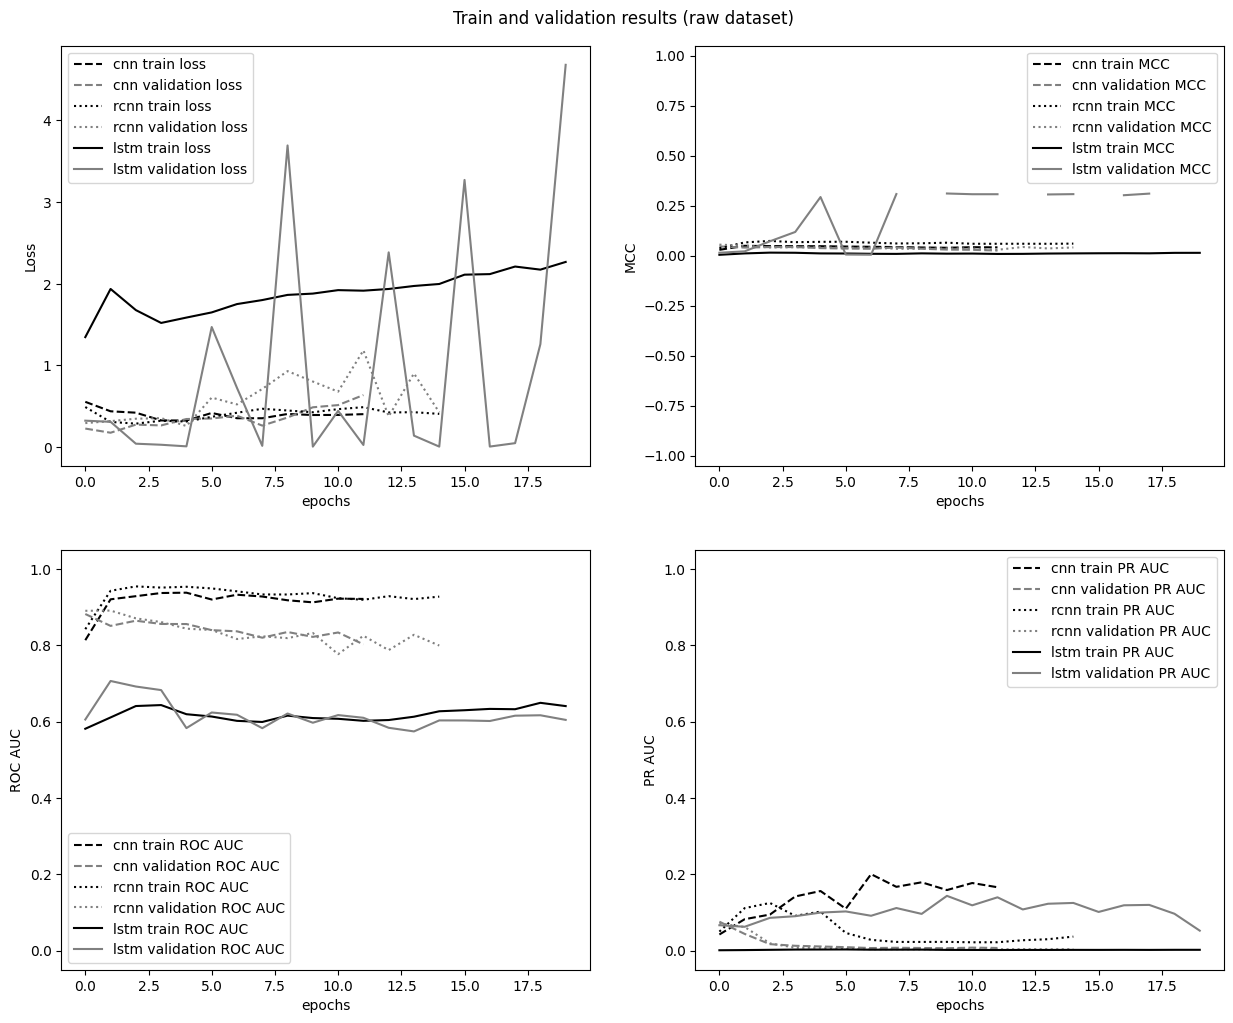

In [6]:
# Displaying train and validation metrics (raw dataset)
plot_results(
    glob(os.path.join("*", "raw", "*_train_metrics.pickle")),
    "Train and validation results (raw dataset)"
)

Given the upper graphs, we can see that the models trained randomly on the raw dataset. The LSTM model has bigger loss values than the others, with some undefined validation MCC values, involving the prediction of only on class. Moreover, both CNN and RCNN validation MCC curves stay near 0.0, as for their PR AUC curves, even if they have good ROC AUC values. The models are unable to detect the relevant features for an accurate classification, even if they are able to distinguish true and false positives.

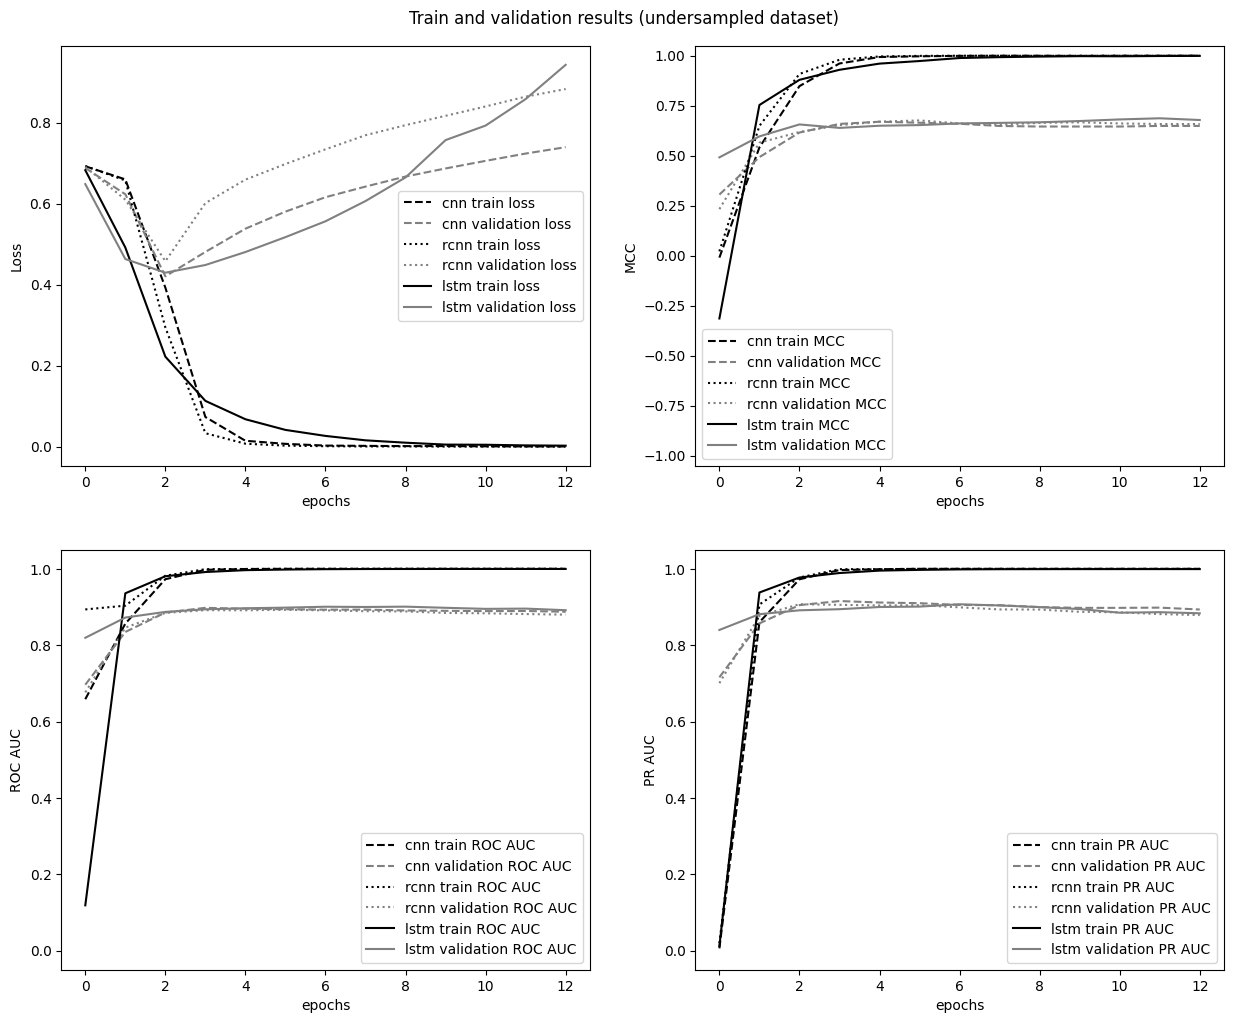

In [7]:
# Displaying train and validation metrics (undersampled dataset)
plot_results(
    glob(os.path.join("*", "undersampled", "*_train_metrics.pickle")),
    "Train and validation results (undersampled dataset)"
)

Given the upper graphs, the models did overfit starting from the third epoch, dispite having good performances. Indeed, they present good ROC and PR AUC curves, but their MCC values are still too low to classify bigrams correctly. This is due to the small amount of samples since the dataset has been undersampled to 4,098 bigrams.

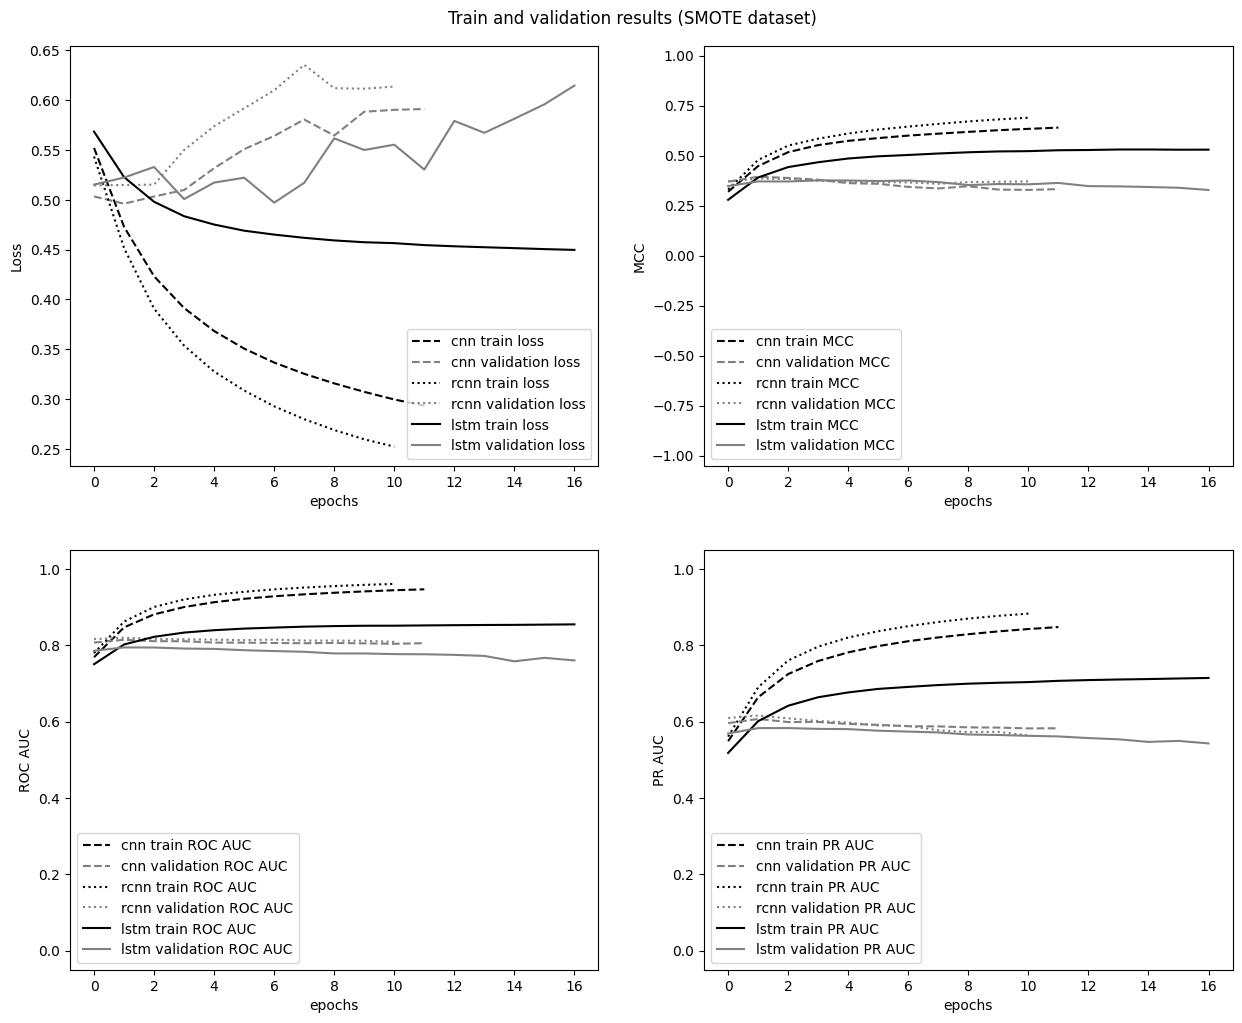

In [8]:
# Displaying train and validation metrics (SMOTE dataset)
plot_results(
    glob(os.path.join("*", "smote", "*_train_metrics.pickle")),
    "Train and validation results (SMOTE dataset)"
)

Given the upper graphs, the models did also overfit, as depicted by their validation loss curves. Compaired to the raw dataset, the models present better MCC, ROC and PR AUC curves, due to more samples from the under-represented class (i.e. tortured sentences). Also, the LSTM presents more similar results to those of both CNN and RCNN.

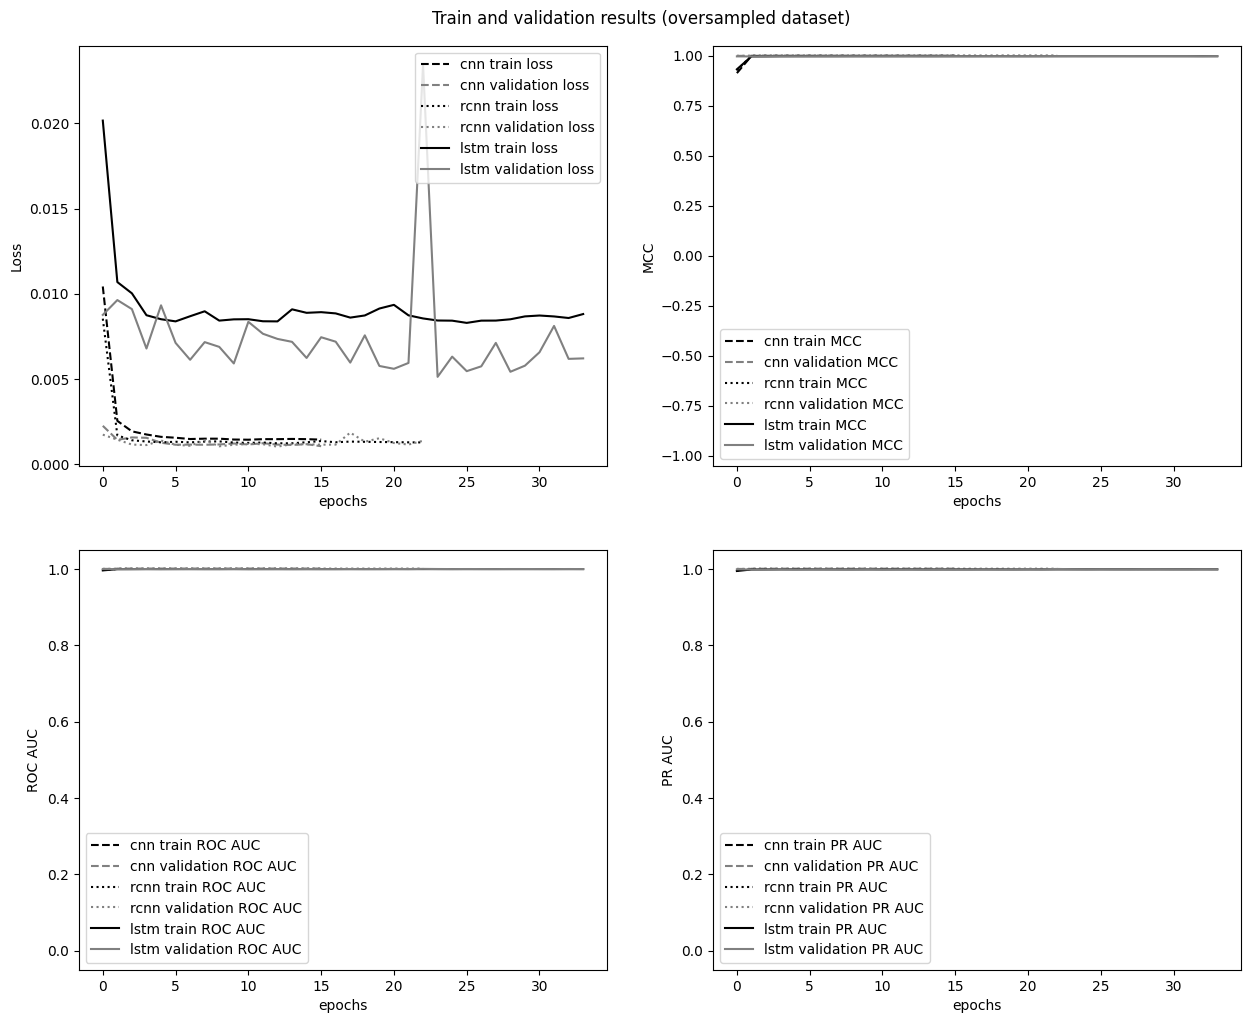

In [9]:
# Displaying train and validation metrics (oversampled dataset)
plot_results(
    glob(os.path.join("*", "oversampled", "*_train_metrics.pickle")),
    "Train and validation results (oversampled dataset)"
)

Then, given the upper figures, the three models present promising results with MCC, ROC and PR AUC values close to 1.0, even if the LSTM has bigger loss values.

We also display the test results for each dataset configuration:

In [10]:
# Displaying test metrics (for each dataset)
raw_test = glob(os.path.join("*", "raw", "*_test_metrics.pickle"))
undersampled_test = glob(os.path.join("*", "undersampled", "*_test_metrics.pickle"))
smote_test = glob(os.path.join("*", "smote", "*_test_metrics.pickle"))
oversampled_test = glob(os.path.join("*", "oversampled", "*_test_metrics.pickle"))
test_metrics = [raw_test , undersampled_test, smote_test, oversampled_test]

for t in test_metrics:
    print("Obtained test metrics on the %s dataset for each model:" % (t[0].split("/")[1]))
    metrics = get_df_test_metrics(t).style.hide(axis="index")
    display(metrics)

Obtained test metrics on the raw dataset for each model:


Model,Loss,MCC,ROC AUC,PR AUC
CNN,0.176456,0.868041,0.082791,0.047160
RCNN,0.259036,0.876580,0.011529,0.049015
LSTM,0.005830,0.643260,0.227702,0.409714


Obtained test metrics on the undersampled dataset for each model:


Model,Loss,MCC,ROC AUC,PR AUC
CNN,0.391622,0.898677,0.931253,0.650594
RCNN,0.377420,0.912486,0.940600,0.676819
LSTM,0.375008,0.907636,0.931866,0.696300


Obtained test metrics on the smote dataset for each model:


Model,Loss,MCC,ROC AUC,PR AUC
CNN,0.496236,0.813426,0.604609,0.392459
RCNN,0.514680,0.815094,0.607303,0.370101
LSTM,0.497568,0.783897,0.572992,0.373808


Obtained test metrics on the oversampled dataset for each model:


Model,Loss,MCC,ROC AUC,PR AUC
CNN,0.001162,0.999887,0.999774,0.999731
RCNN,0.001152,0.999883,0.999766,0.999734
LSTM,0.004907,0.999497,0.998997,0.998315


Given the obtained test values for each model and dataset configuration, we can see that the LSTM performs not as good as both CNN and RCNN when the dataset is imbalanced. These two models present very promising performances for bigrams classification, especially on the oversampled dataset.

## Conclusion

We trained three neural networks, a LSTM, a CNN, and a combination of these two through a RCNN, on four dataset configurations. The raw dataset is hugely imbalanced, with 2,049 tortured bigrams for 2,680,825 (the tortured bigrams represent ~0.07% of the dataset). The undersampled dataset is very small, with 4,098 samples, even if it is balanced. The SMOTE dataset presents 536,165 sequence vectors considered as "tortured", equivalent to 20% of the other class, the dataset is still imabalanced. Finally, the oversampled dataset offers a total of 5,361,650 samples to be trained on, it is also balanced.

Even if our best solution (i.e. the models trained on the oversampled dataset) has promising results, it stays very generalised. This is due to the applied augmentation technique, creating artificial samples from the sequence matrix, not representating any real turtured bigram. This solution could have lesser good results with another dataset.

If you have any question, please contact us at first_name DOT last_name AT irit DOT fr.